<a href="https://colab.research.google.com/github/LokeshSaipureddi/Diabetic_retinopathy/blob/main/FPN_messidor2_without_image_processing_and_FPN_mobilenetv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install -q kaggle

In [3]:
import tensorflow as tf

In [4]:
!pip install pydot

In [5]:
print(tf.__version__)

2.6.0


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d 'xyaustin/messidor2'

100% 2.29G/2.29G [01:04<00:00, 27.4MB/s]
100% 2.29G/2.29G [01:04<00:00, 38.3MB/s]


In [9]:
!mkdir messidor2

In [10]:
! unzip messidor2.zip -d messidor2

Archive:  messidor2.zip
  inflating: messidor2/messidor-2/images/20051020_43808_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_43832_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_43882_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_43906_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44261_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44284_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44338_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44349_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44400_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44431_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44598_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44636_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44692_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44714_0100_PP.pn

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout,Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.metrics import AUC,Precision,Recall
from sklearn.model_selection import KFold
import math
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import random
import shutil
import glob

In [12]:
import os
os.mkdir("/content/messidor2/messidor-2/0")
os.mkdir("/content/messidor2/messidor-2/1")
os.mkdir("/content/messidor2/messidor-2/2")
os.mkdir("/content/messidor2/messidor-2/3")
os.mkdir("/content/messidor2/messidor-2/4")

In [13]:
import os
os.remove("/content/messidor2/messidor-2/images/20060411_58550_0200_PP.png")
os.remove("/content/messidor2/messidor-2/images/IM002385.jpg")
os.remove("/content/messidor2/messidor-2/images/IM003718.jpg")
os.remove("/content/messidor2/messidor-2/images/IM004176.jpg")
# importing pandas module


In [14]:
import pandas as pd

# making data frame from csv file
data = pd.read_csv("/content/messidor2/messidor-2/messidor_data.csv")

# making new data frame with dropped NA values
data.dropna(subset=["adjudicated_dr_grade"],inplace=True)
data.to_csv('messidor_data2.csv')
# comparing sizes of data frames
print("Old data frame length:", len(data))

os.remove("/content/messidor2/messidor-2/messidor_data.csv")
import shutil
shutil.move("/content/messidor_data2.csv","/content/messidor2/messidor-2")


Old data frame length: 1744


'/content/messidor2/messidor-2/messidor_data2.csv'

In [15]:
import shutil, os
import pandas as pd

labels = pd.read_csv("/content/messidor2/messidor-2/messidor_data2.csv")
labels = labels.sort_values('adjudicated_dr_grade')

In [16]:
class_names = list(labels.adjudicated_dr_grade.unique())
print(class_names)

[0.0, 1.0, 2.0, 3.0, 4.0]


In [17]:
class_names = list(labels.adjudicated_dr_grade.unique())
A = [int(class_names) for class_names in class_names]
print(A)

[0, 1, 2, 3, 4]


In [18]:
for c in A: # Category Name
  for i in list(labels[labels['adjudicated_dr_grade']==c]['image_id']): # Image Id
    get_image = os.path.join('/content/messidor2/messidor-2/images/', i) # Path to Images
    move_image_to_cat = shutil.copy(get_image, '/content/messidor2/messidor-2/'+str(c))

In [19]:
ls1=os.listdir('/content/messidor2/messidor-2/1')
ls2=os.listdir('/content/messidor2/messidor-2/2')
ls3=os.listdir('/content/messidor2/messidor-2/3')
ls4=os.listdir('/content/messidor2/messidor-2/4')
os.mkdir('/content/messidor2/messidor-2/comb1234')

In [20]:
path='/content/messidor2/messidor-2'
dest='/content/messidor2/messidor-2/comb1234'
for i in ls1:
  img_scr=path+'/1/'+str(i)
  shutil.move(img_scr,dest)

In [21]:
path='/content/messidor2/messidor-2'
dest='/content/messidor2/messidor-2/comb1234'
for i in ls2:
  img_scr=path+'/2/'+str(i)
  shutil.move(img_scr,dest)

In [22]:
path='/content/messidor2/messidor-2'
dest='/content/messidor2/messidor-2/comb1234'
for i in ls3:
  img_scr=path+'/3/'+str(i)
  shutil.move(img_scr,dest)

In [23]:
path='/content/messidor2/messidor-2'
dest='/content/messidor2/messidor-2/comb1234'
for i in ls4:
  img_scr=path+'/4/'+str(i)
  shutil.move(img_scr,dest)

In [24]:
for i in range(1,5):
  shutil.rmtree('/content/messidor2/messidor-2/'+str(i))

In [25]:
os.rename('/content/messidor2/messidor-2/comb1234','/content/messidor2/messidor-2/1')

In [26]:
original_data_path = "/content/messidor2/messidor-2"
train_pct = 0.8
test_pct = 0.1
val_pct = 0.1

if os.path.isdir("/content/messidor2/messidor-2/train/0") is False:
    # create folders for the sets
    os.mkdir("/content/messidor2/messidor-2/train")
    os.mkdir("/content/messidor2/messidor-2/test")
    os.mkdir("/content/messidor2/messidor-2/validation")
    for i in range(0, 2):
        # path to inputs with different classes
        num_folder_path = f'{original_data_path}/{i}' 
        num_files_in_folder = len(os.listdir(num_folder_path))
        train_size1 = int(num_files_in_folder * train_pct)
        test_size1 = int(num_files_in_folder * test_pct)
        val_size = int(num_files_in_folder * val_pct)
        train_size = train_size1
        test_size = test_size1
        os.mkdir(f'/content/messidor2/messidor-2/train/{i}')
        os.mkdir(f'/content/messidor2/messidor-2/test/{i}')
        os.mkdir(f'/content/messidor2/messidor-2/validation/{i}')
        test_samples = random.sample(os.listdir(num_folder_path), test_size)
        for file_name in test_samples:
            shutil.move((f"/content/messidor2/messidor-2/{i}/{file_name}"), f'/content/messidor2/messidor-2/test/{i}')
        val_samples = random.sample(os.listdir(num_folder_path), val_size)
        for file_name in val_samples:
            shutil.move((f"/content/messidor2/messidor-2/{i}/{file_name}"), f'/content/messidor2/messidor-2/validation/{i}')    
        train_samples = random.sample(os.listdir(num_folder_path), train_size)
        for file_name in train_samples:
            shutil.move((f"/content/messidor2/messidor-2/{i}/{file_name}"), f'/content/messidor2/messidor-2/train/{i}')

In [27]:
train_path="/content/messidor2/messidor-2/train"
test_path="/content/messidor2/messidor-2/test"
val_path='/content/messidor2/messidor-2/validation'

In [28]:
shape=(512,512,1)

In [29]:
# CLASS_MODE = "categorical"
# BATCH_SIZE = 16
# train_batches = ImageDataGenerator(rescale=1./223,
#                                    featurewise_center=True,
#     brightness_range=[-0.3,0.3],
    
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True).flow_from_directory(directory = train_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE,shuffle=True)
# val_batches = ImageDataGenerator(rescale=1./223).flow_from_directory(directory = val_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)
# test_batches = ImageDataGenerator(rescale=1./223).flow_from_directory(directory = test_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)

In [30]:
CLASS_MODE = "categorical"
BATCH_SIZE = 16
train_batches = ImageDataGenerator(rescale=1./223,
                                   featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True).flow_from_directory(directory = train_path, target_size = (224,224), batch_size = BATCH_SIZE, class_mode=CLASS_MODE,shuffle=True)
val_batches = ImageDataGenerator(rescale=1./223).flow_from_directory(directory = val_path, target_size = (224,224), batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)
test_batches = ImageDataGenerator(rescale=1./223).flow_from_directory(directory = test_path, target_size =(224,224), batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)

Found 1394 images belonging to 2 classes.
Found 173 images belonging to 2 classes.
Found 173 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


<Figure size 432x288 with 0 Axes>

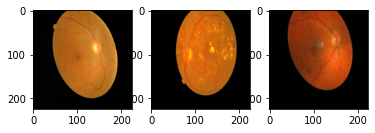

In [31]:
plt.figure()
f, axarr = plt.subplots(1,3)
for i in range (0,3):
    random_num = random.randint(0,5)
    image = train_batches[random_num]
    axarr[i].imshow(image[0][0])
    print(np.shape(image[0][0])) 

In [32]:
IMG_SIZE = (224,224)
batch_size = 64
epoch = 200

In [33]:
import tensorflow 
from tensorflow import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dropout, Flatten, Dense,Input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image
import tensorflow.keras.backend as k

In [34]:
from tensorflow.keras.metrics import AUC, Precision, Recall, FalseNegatives, FalsePositives,TrueNegatives,TruePositives, CategoricalCrossentropy

In [57]:
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
x = Flatten()(model.layers[-40].output)
x=Dropout(0.4)(x)
x=Dense(units=1024)(x)
x=Dropout(0.5)(x)
output = Dense(units=2, activation="sigmoid")(x)
model = Model(inputs = model.input, outputs = output)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [58]:
initial_lrate = 0.0001 #0001
def decay(epoch, steps=10):
    initial_lrate = 0.0001
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
opt = RMSprop(lr=initial_lrate)
lr_sc = LearningRateScheduler(decay, verbose=1)
model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy',AUC(),Precision(),Recall(),FalsePositives(),TrueNegatives(),TruePositives(),FalseNegatives()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [59]:
checkpoint = ModelCheckpoint("weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, mode='auto',patience=25)
callback = [checkpoint]
hist = model.fit(train_batches, validation_data=test_batches , epochs=30,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
88/88 [==============================] - 120s 1s/step - loss: 9.3123 - accuracy: 0.5581 - auc_5: 0.5661 - precision_5: 0.5703 - recall_5: 0.4742 - false_positives_5: 498.0000 - true_negatives_5: 896.0000 - true_positives_5: 661.0000 - false_negatives_5: 733.0000 - val_loss: 9.6369 - val_accuracy: 0.5838 - val_auc_5: 0.5917 - val_precision_5: 0.5838 - val_recall_5: 0.5838 - val_false_positives_5: 72.0000 - val_true_negatives_5: 101.0000 - val_true_positives_5: 101.0000 - val_false_negatives_5: 72.0000

Epoch 00001: val_accuracy improved from -inf to 0.58382, saving model to weights.h5
Epoch 2/30
88/88 [==============================] - 105s 1s/step - loss: 8.5626 - accuracy: 0.5890 - auc_5: 0.5946 - precision_5: 0.5821 - recall_5: 0.5265 - false_positives_5: 527.0000 - true_negatives_5: 867.0000 - true_positives_5: 734.0000 - false_negatives_5: 660.0000 - val_loss: 6.7997 - val_accuracy: 0.5838 - val_auc_5: 0.6203 - val_precision_5: 0.5814 - val_recall_5: 0.5780 - val_false_p

In [60]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [61]:
target_names = []

for key in train_batches.class_indices:

    target_names.append(key)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix


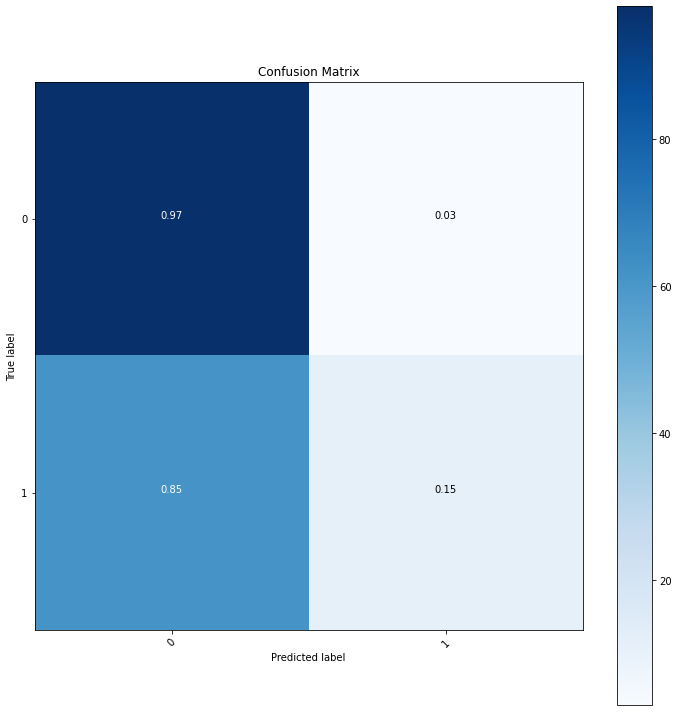

In [62]:
Y_pred = model.predict_generator(test_batches)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_batches.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [63]:
model.load_weights('/content/weights.h5')

In [64]:
model_metrics = model.evaluate(test_batches,verbose=0)

In [65]:
f1_score = 2*( (model_metrics[3]*model_metrics[4]) / (model_metrics[3]+model_metrics[4]) )

In [66]:
print(f"Accuracy on test set: {round(model_metrics[1]*100,2)}%")
print(f"ROC(Receiver Operation Characteristic) AUC(Area Under Curve): {model_metrics[2]}")
print(f"Precision: {round(model_metrics[3]*100,2)}%")
print(f"Recall: {round(model_metrics[4]*100,2)}%")
print(f"F1-score: {f1_score}")
print(f"Specificity: {(model_metrics[6])/(model_metrics[6]+model_metrics[5])}")

Accuracy on test set: 65.9%
ROC(Receiver Operation Characteristic) AUC(Area Under Curve): 0.7010257244110107
Precision: 57.94%
Recall: 84.39%
F1-score: 0.6870588287663705
Specificity: 0.3872832369942196


In [ ]:
lr_probs = model.predict(test_batches)

In [ ]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(test_batches.classes, y_pred)

In [ ]:
fpr1

array([0.        , 0.03960396, 1.        ])

In [ ]:
thresh1

array([2, 1, 0])

In [ ]:
fpr1, tpr1, thresh1 = roc_curve(test_batches.classes, y_pred)

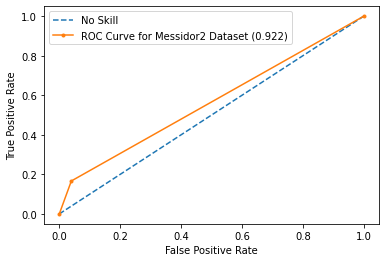

In [ ]:
from matplotlib import pyplot
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
pyplot.plot(fpr1, tpr1, marker='.', label='ROC Curve for Messidor2 Dataset (0.922)')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()